In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Load your dataset
file_path = '/content/Group_Exercise_Dataset.csv'
dataset = pd.read_csv(file_path)


In [8]:
#### PREPROCESSING
# Checking for missing values
print("Missing values before imputation:\n", dataset.isnull().sum())

# Handling missing values using column means
dataset_mean_imputed = dataset.fillna(dataset.mean())
print("\nMissing values after imputation:\n", dataset_mean_imputed.isnull().sum())

# Handling outliers using the IQR method
dataset_iqr_cleaned = dataset_mean_imputed.copy()

for column in dataset_iqr_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = dataset_iqr_cleaned[column].quantile(0.25)
    Q3 = dataset_iqr_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile range

    # Defining lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers to the lower and upper bounds
    dataset_iqr_cleaned[column] = dataset_iqr_cleaned[column].clip(lower=lower_bound, upper=upper_bound)

print("\nData after handling outliers (first 5 rows):")
print(dataset_iqr_cleaned.head())

# Step 4: Selecting numerical features for Min-Max Scaling
numerical_features = dataset_iqr_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Step 5: Applying Min-Max Scaling
dataset_scaled = dataset_iqr_cleaned.copy()
dataset_scaled[numerical_features] = minmax_scaler.fit_transform(dataset_iqr_cleaned[numerical_features])

print("\nData after Min-Max Scaling (first 5 rows):")
print(dataset_scaled.head())



X = dataset_scaled.iloc[:, :-1]
y = dataset_scaled.iloc[:, -1]

# Step 6: Apply RFE to select 2 features
model = LinearRegression()
rfe = RFE(model, n_features_to_select=2)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_].tolist()
print("Selected Features with RFE:", selected_features)

Missing values before imputation:
 fBodyGyro-bandsEnergy()-49,56         112
fBodyGyro-bandsEnergy()-49,56.1       118
fBodyGyro-bandsEnergy()-49,56.2       114
fBodyAcc-bandsEnergy()-25,48          109
fBodyAcc-bandsEnergy()-25,48.1        114
fBodyAcc-bandsEnergy()-25,48.2        100
fBodyAccJerk-mad()-X                  121
fBodyAcc-entropy()-Y                  119
tBodyAcc-mad()-X                       97
tGravityAcc-max()-Y                   120
fBodyAccJerk-std()-Y                  101
tBodyAcc-correlation()-X,Y            110
tGravityAcc-min()-X                    91
tGravityAcc-correlation()-X,Y         107
fBodyAccJerk-bandsEnergy()-33,40      105
fBodyAccJerk-bandsEnergy()-33,40.1    114
fBodyAccJerk-bandsEnergy()-33,40.2    130
fBodyAcc-skewness()-Y                 114
tBodyAccJerkMag-max()                 109
tBodyAccJerk-energy()-Z               116
fBodyAcc-energy()-X                   118
tBodyAccJerk-arCoeff()-Y,3            117
tBodyGyroJerkMag-min()                119

In [12]:
### Build and Evaluate Models

## Using multiple Linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Multiple Linear Regression model
lin_reg_multi = LinearRegression()
lin_reg_multi.fit(X_train, y_train)

# Predicting on the test set
y_pred_multi = lin_reg_multi.predict(X_test)

# Calculate RMSE and R2 Score
rmse_multi = np.sqrt(mean_squared_error(y_test, y_pred_multi))
r2_multi = r2_score(y_test, y_pred_multi)

# Output results
print("Multiple Linear Regression Results:")
print("RMSE:", rmse_multi)
print("R2 Score:", r2_multi)

# K Fold Cross Validation using 5 Fold
lr = LinearRegression()

# Specifying  K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate R2 scores on the dataset
cv_scores = cross_val_score(lr, X, y, cv=kf, scoring='r2')

# Output the scores and their mean
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores):.2f}")

Multiple Linear Regression Results:
RMSE: 0.24415715370988375
R2 Score: 0.5940886010903669
Cross-Validation R2 Scores: [0.5940886  0.59574126 0.57698528 0.52918929 0.5933598 ]
Mean CV R2 Score: 0.58


In [14]:
#Enhance the model


#Experimenting  with feature selection techniques and analyze their impact
# Applying  SelectKBest with mutual information regression for feature selection
mi_selector = SelectKBest(score_func=mutual_info_regression, k="all")
mi_selector.fit(X, y)

# Create a DataFrame to display the mutual information scores
mi_scores = pd.DataFrame({
    "Feature": X.columns,
    "Mutual_Info_Score": mi_selector.scores_
}).sort_values(by="Mutual_Info_Score", ascending=False)

# Display the sorted mutual information scores
print(mi_scores)

                               Feature  Mutual_Info_Score
39      fBodyGyro-bandsEnergy()-1,16.2           1.830704
30                   fBodyGyro-mad()-Z           1.616414
38      fBodyGyro-bandsEnergy()-1,16.1           0.940012
6                 fBodyAccJerk-mad()-X           0.937670
27               tBodyGyroJerk-mad()-Y           0.925948
8                     tBodyAcc-mad()-X           0.918986
7                 fBodyAcc-entropy()-Y           0.891660
10                fBodyAccJerk-std()-Y           0.845530
20                 fBodyAcc-energy()-X           0.840734
18               tBodyAccJerkMag-max()           0.820693
37        fBodyGyro-bandsEnergy()-1,16           0.804335
19             tBodyAccJerk-energy()-Z           0.797190
15  fBodyAccJerk-bandsEnergy()-33,40.1           0.785238
14    fBodyAccJerk-bandsEnergy()-33,40           0.774813
2      fBodyGyro-bandsEnergy()-49,56.2           0.756012
22              tBodyGyroJerkMag-min()           0.755871
3         fBod

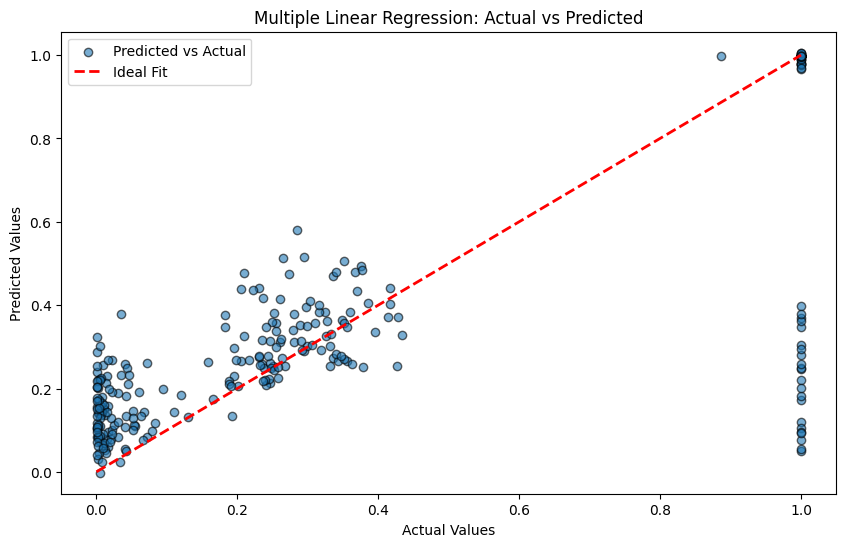

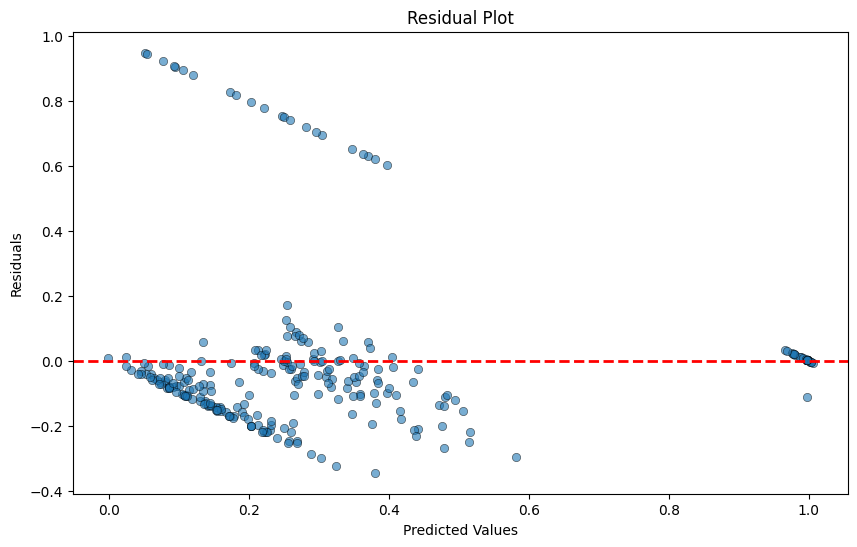

In [16]:
## VISUALIZATION

# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_multi, alpha=0.6, edgecolor='k', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Ideal Fit')
plt.title('Multiple Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()




# Generate predictions
y_pred = lin_reg_multi.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor="k")
plt.axhline(y=0, color="r", linestyle="--", linewidth=2)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

Lasso Regression - R2: 0.59, RMSE: 0.25


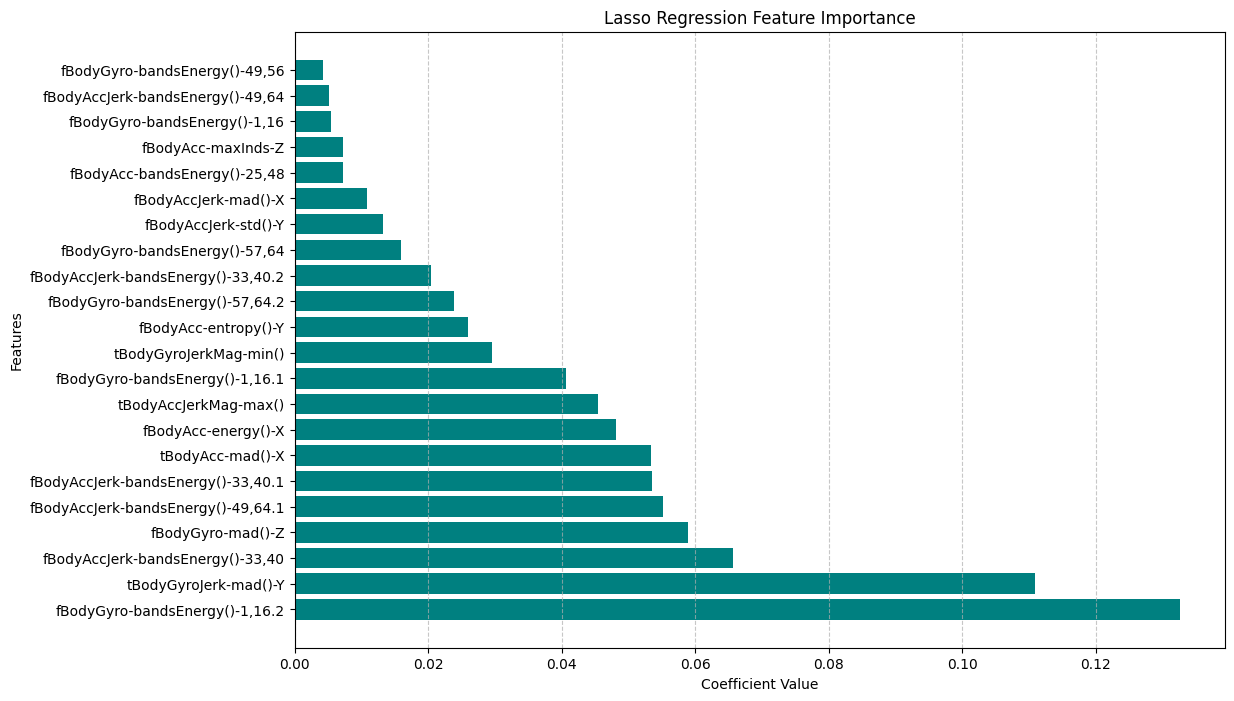

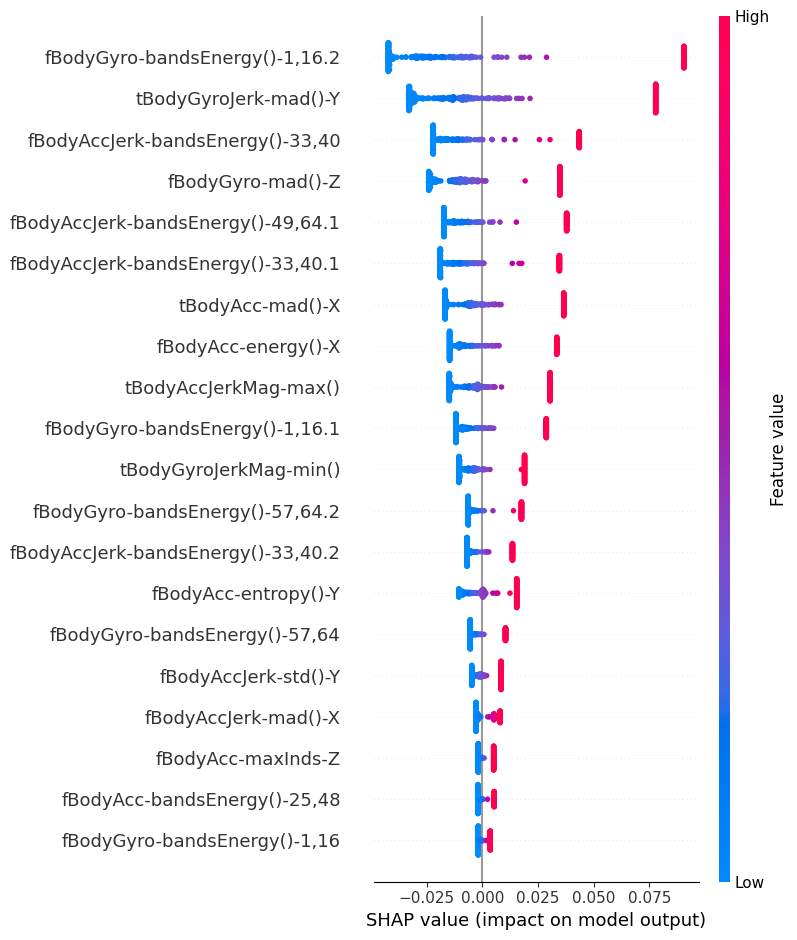

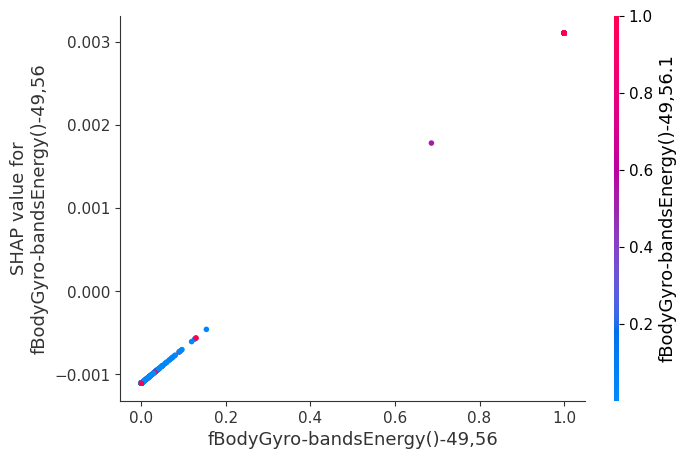

In [20]:
### Creativity

# Using Lasso Regression for creativity


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

# Evaluate the model
y_pred = lasso.predict(X_test)
lasso_r2 = r2_score(y_test, y_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Lasso Regression - R2: {lasso_r2:.2f}, RMSE: {lasso_rmse:.2f}")



# Visualize Feature Importance
lasso_coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso.coef_
}).sort_values(by="Coefficient", ascending=False)

# Filter out zero coefficients
lasso_coefficients = lasso_coefficients[lasso_coefficients["Coefficient"] != 0]

# Plot the coefficients
plt.figure(figsize=(12, 8))
plt.barh(lasso_coefficients["Feature"], lasso_coefficients["Coefficient"], color="teal")
plt.title("Lasso Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# SHAP Analysis
explainer = shap.Explainer(lasso, X_train)  # Create SHAP explainer
shap_values = explainer(X_test)  # Compute SHAP values

# SHAP summary plot
shap.summary_plot(shap_values, X_test)

# SHAP dependence plot for the first feature
shap.dependence_plot(0, shap_values.values, X_test)